<a href="https://colab.research.google.com/github/Ozzuke/GDELT-BTC/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlating significant world events to changes in Bitcoin price
Osvald Nigola & Leo-Martin Pala, 2024

## Abstract

This project explores the relationship between global events and cryptocurrency markets by analyzing GDELT Events 2.0 data and Bitcoin price movements from 2019 to 2023. Using data science techniques and statistical analysis, we investigate whether significant world events can predict or correlate with Bitcoin price fluctuations. Our research contributes to understanding the external factors influencing cryptocurrency markets and their relationship with global events.

## Table of contents

1. Introduction
2. Data Sources and Preprocessing
   - GDELT dataset
   - Bitcoin price data
3. Exploratory Data Analysis
4. Methodology
5. Analysis and Results
6. Discussion
7. Conclusion
8. References

# 1. Introduction
The cryptocurrency market is known for its high volatility, with Bitcoin prices capable of dramatic shifts within hours or even minutes. This inherent volatility suggests that the market might be particularly responsive to external stimuli, including significant world events. While various factors such as market sentiment, technological developments, and regulatory changes are known to influence cryptocurrency prices, the relationship between global events and Bitcoin price movements remains less thoroughly explored. This project, conducted as part of the "Introduction to Data Science" course at the University of Tartu in the autumn semester of 2024, aims to investigate whether and how major world events captured in the GDELT Events 2.0 database correlate with Bitcoin price fluctuations during the period of 2019-2023.

# 2. Data Sources and Preprocessing
The analysis in this project is based on two primary datasets: the GDELT Events 2.0 dataset and Bitcoin price data. The GDELT dataset provides information on significant world events, including the actors involved, event types, locations, and other relevant details. The Bitcoin price data captures the minute-by-minute price movements of Bitcoin over the same period. In this section, we describe the data sources, their preprocessing steps, and the resulting datasets used for the analysis.

## Data Sources

### GDELT dataset
The GDELT dataset is huge and processing it as a whole would not be possible in the scope of this project. The reduced size GDELT data was obtained from Google BigQuery using the following query:
```sql
SELECT
  SQLDATE,
  Actor1CountryCode,
  Actor1Type1Code,
  Actor2CountryCode,
  Actor2Type1Code,
  IsRootEvent,
  EventCode,
  QuadClass,
  GoldsteinScale,
  NumMentions,
  NumSources,
  NumArticles,
  AvgTone,
  Actor1Geo_CountryCode,
  Actor2Geo_CountryCode,
  ActionGeo_ADM1Code
FROM `gdelt-bq.gdeltv2.events`
WHERE
  SQLDATE BETWEEN 20190101 AND 20231231
  AND NumArticles > 10  -- Basic significance filter
  AND NumMentions > 5  -- Basic mention filter
```
It includes world events from 2019-2023 and is less than 600MB in size. Not all columns were used in the analysis. The query cost in BigQuery was about 70GB and the data was exported to GitHub LFS for easier access.

#### GDELT data description post-processed
Columns which were not used in the analysis are not listed here. The column names and dtypes may differ from the original dataset due to post-processing. This is the final form of the dataset used in the analysis.
- **date** (*datetime*) : The date of the event in YYYYMMDD format.  
- **Actor1CountryCode** (*string*) : The 3-character CAMEO code for the country affiliation of Actor1. May be blank if the system was unable to identify an Actor1 or determine its country affiliation (such as “UNIDENTIFIED GUNMEN”).  
- **Actor1Type1Code** (*string*) : The 3-character CAMEO code of the CAMEO “type” or “role” of Actor1, if specified. This can be a specific role such as Police Forces, Government, Military, Political Opposition, Rebels, etc, a broad role class such as Education, Elites, Media, Refugees, or organizational classes like Non-Governmental Movement. Special codes such as Moderate and Radical may refer to the operational strategy of a group.  
- **Actor1Geo_CountryCode** (*string*) : This is the 2-character FIPS10-4 country code for the location.  
- **Actor2CountryCode** (*string*) : ... for Actor2.  
- **Actor2Type1Code** (*string*) : ... for Actor2.  
- **Actor2Geo_CountryCode** (*string*) : ... for Actor2.  
- **Actor1Geo_ADM1Code** (*string*) : This is the 2-character FIPS10-4 country code followed by the 2-character FIPS10-4 administrative division 1 (ADM1) code for the administrative division housing the landmark. In the case of the United States, this is the 2-character shortform of the state’s name (such as “TX” for Texas).  
- **IsRootEvent** (*int*) : The system codes every event found in an entire document, using an array of techniques to deference and link information together. A number of previous projects such as the ICEWS initiative have found that events occurring in the lead paragraph of adocument tend to be the most “important.” This flag can therefore be used as a proxy for the rough importance of an event to create subsets of the event stream.
- **EventCode** (*string*) : This is the raw CAMEO action code describing the action that Actor1 performed upon Actor2. This is the most detailed coding of the action that is possible.  
- **QuadClass** (*int*) : The QuadClass field is a CAMEO code field that identifies the general category of the type of action that Actor1 performed upon Actor2. (1=Verbal Cooperation, 2=Material Cooperation, 3=Verbal Conflict, 4=Material Conflict)  
- **GoldsteinScale** (*float*) : Each CAMEO event code is assigned a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country. This is known as the Goldstein Scale. This field specifies the Goldstein score for each event type.  
- **NumMentions** (*int*) : This is the total number of mentions of this event across all source documents during the 15 minute update in which it was first seen. Multiple references to an event within a single document also contribute to this count. This can be used as a method of assessing the “importance” of an event: the more discussion of that event, the more likely it is to be significant. The total universe of source documents and the density of events within them vary over time, so it is recommended that this field be normalized by the average or other measure of the universe of events during the time period of interest. This field is actually a composite score of the total number of raw mentions and the number of mentions extracted from reprocessed versions of each article (see the discussion for the Mentions table).  
- **NumSources** (*int*) : This is the total number of information sources containing one or more mentions of this event during the 15 minute update in which it was first seen. This can be used as a method of assessing the “importance” of an event: the more discussion of that event, the more likely it is to be significant. The total universe of sources varies over time, so it is recommended that this field be normalized by the average or other measure of the universe of events during the time period of interest.  
- **NumArticles** (*int*) : This is the total number of source documents containing one or more mentions of this event during the 15 minute update in which it was first seen. This can be used as a method of assessing the “importance” of an event: the more discussion of that event, the more likely it is to be significant. The total universe of source documents varies over time, so it is recommended that this field be normalized by the average or other measure of the universe of events during the time period of interest.  
- **AvgTone** (*numeric*) : This is the average “tone” of all documents containing one or more mentions of this event during the 15 minute update in which it was first seen. The score ranges from -100 (extremely negative) to +100 (extremely positive). Common values range between -10 and +10, with 0 indicating neutral. This can be used as a method of filtering the “context” of events as a subtle measure of the importance of an event and as a proxy for the “impact” of that event. For example, a riot event with a slightly negative average tone is likely to have been a minor occurrence, whereas if it had an extremely negative average tone, it suggests a far more serious occurrence. A riot with a positive score likely suggests a very minor  occurrence described in the context of a more positive narrative (such as a report of an attack occurring in a discussion of improving conditions on the ground in a country and how the number of attacks per day has been greatly reduced).  

Reference: [GDELT Event Codebook V2.0](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf).

Some descriptions are shortened or changed for clarity. The codebook details the full descriptions of columns in the dataset, many of which were not used in this analysis and therefore not included here.

### Bitcoin price dataset
The data includes minute-by-minute price data for Bitcoin from 2012 to 2023 and was obtained from [Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data). The dataset is about 350MB in size and includes the following columns:
- **Timestamp** (*int*) : Start time of time window (60s window), in Unix time seconds
- **Open** (*float*) : Price at the start of the time window
- **High** (*float*) : Highest price during the time window
- **Low** (*float*) : Lowest price during the time window
- **Close** (*float*) : Price at the end of the time window
- **Volume** (*float*) : Amount of Bitcoin traded during the time window

#### Bitcoin price dataset post-processed
The dataset was preprocessed to a more usable format for the analysis. This is the final form of the dataset used in the analysis.
- **date** (*datetime*) : The date of the price data.
- **Open** (*float*) : Price at the start of the time window.
- **High** (*float*) : Highest price during the time window.
- **Low** (*float*) : Lowest price during the time window.
- **Close** (*float*) : Price at the end of the time window.
- **Volume** (*float*) : Amount of Bitcoin traded during the time window.
- **Change** (*float*) : Change in price from Open to Close.
- **Change%** (*float*) : Percentage change in price from Open to Close.
- **Fluctuation** (*float*) : Difference between High and Low prices.
- **Fluctuation%** (*float*) : Percentage fluctuation between High and Low prices.

## Loading data
The data is loaded from GitHub and cached locally to speed up the process.

In [192]:
from xml.etree.ElementInclude import include

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from holoviews.plotting.bokeh.styles import alpha, color

In [193]:
gdelt_data_url = 'https://github.com/Ozzuke/GDELT-BTC/raw/refs/heads/main/datasets/GDELT_significant_events.csv'
bitcoin_data_url = 'https://github.com/Ozzuke/GDELT-BTC/raw/refs/heads/main/datasets/BTC_USD_1min.csv'

In [194]:
def load_cached_data(url, cache_name, csv_sep=',', df_dtype=None):
    """
    Load data from cache if it exists, otherwise download and cache it
    """
    cache_file = f'cache/{cache_name}.parquet'

    # Check if cache directory exists
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    # Check if cache exists
    if os.path.exists(cache_file):
        print(f"Loading {cache_name} from cache...")
        return pd.read_parquet(cache_file)

    # If no cache, download and create cache
    print(f"Downloading {cache_name} from GitHub...")
    if df_dtype is None:
        df = pd.read_csv(url, sep=csv_sep)
    else:
        df = pd.read_csv(url, sep=csv_sep, dtype=df_dtype)

    # Save to cache
    print(f"Creating cache for {cache_name}...")
    df.to_parquet(cache_file)

    return df

In [195]:
gdelt = load_cached_data(gdelt_data_url, 'gdelt_cache', csv_sep='\t', df_dtype='str')
bitcoin = load_cached_data(bitcoin_data_url, 'bitcoin_cache')

Loading gdelt_cache from cache...
Loading bitcoin_cache from cache...


## Data preprocessing
The data is preprocessed to be in a more usable format for the analysis.

### GDELT data preprocessing

In [196]:
gdelt.head()

,SQLDATE,Actor1CountryCode,Actor1Type1Code,Actor2CountryCode,Actor2Type1Code,IsRootEvent,EventCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_CountryCode,Actor2Geo_CountryCode,ActionGeo_ADM1Code,DateAdded
0,20230801,EUR,None,AFR,None,1,051,1,3.4,20,2,20,3.34501467963848,EG,EG,EG02,20230801153000
1,20200729,None,None,None,None,1,020,1,3.0,42,1,42,-3.35492704288747,AU,None,AU,20200729104500
2,20200406,None,MED,None,None,1,046,1,7.0,20,2,20,1.13636363636363,TU,None,TU34,20200406104500
3,20200615,None,UAF,USA,None,1,193,4,-10.0,44,1,24,-8.62490241207734,US,US,USTX,20200615143000
4,20190130,None,GOV,AFG,None,0,110,3,-2.0,16,4,16,-2.22138313668064,US,AF,USDC,20190130143000


In [197]:
# drop rows that are not root events as they are less significant
print(f"Before dropping non-root events:\t{gdelt.shape[0]}")
gdelt = gdelt[gdelt.IsRootEvent == '1']
print(f"After dropping non-root events: \t{gdelt.shape[0]}")
gdelt = gdelt.drop(columns=['IsRootEvent'])

Before dropping non-root events:	7428230
After dropping non-root events: 	5154272


In [198]:
# convert SQLDATE to datetime
gdelt = gdelt.rename(columns={'SQLDATE': 'date'})
gdelt['date'] = pd.to_datetime(gdelt['date'], format='%Y%m%d')

# convert numeric columns to numeric
gdelt['GoldsteinScale'] = pd.to_numeric(gdelt['GoldsteinScale'], errors='coerce')
gdelt['NumMentions'] = pd.to_numeric(gdelt['NumMentions'], errors='coerce')
gdelt['NumSources'] = pd.to_numeric(gdelt['NumSources'], errors='coerce')
gdelt['NumArticles'] = pd.to_numeric(gdelt['NumArticles'], errors='coerce')
gdelt['AvgTone'] = pd.to_numeric(gdelt['AvgTone'], errors='coerce')

# convert categorical columns to categorical
gdelt['Actor1CountryCode'] = gdelt['Actor1CountryCode'].astype('category')
gdelt['Actor1Type1Code'] = gdelt['Actor1Type1Code'].astype('category')
gdelt['Actor2CountryCode'] = gdelt['Actor2CountryCode'].astype('category')
gdelt['Actor2Type1Code'] = gdelt['Actor2Type1Code'].astype('category')
gdelt['QuadClass'] = gdelt['QuadClass'].astype('category')
gdelt['Actor1Geo_CountryCode'] = gdelt['Actor1Geo_CountryCode'].astype('category')
gdelt['Actor2Geo_CountryCode'] = gdelt['Actor2Geo_CountryCode'].astype('category')
gdelt['ActionGeo_ADM1Code'] = gdelt['ActionGeo_ADM1Code'].astype('category')

In [199]:
# drop where eventcode is not numeric
gdelt = gdelt[gdelt.EventCode.str.isnumeric()]

In [200]:
print(f"dropna would reduce rows {gdelt.shape[0]} -> {gdelt.dropna().shape[0]}")

dropna would reduce rows 5154269 -> 48712


This is a significant reduction, so we will keep the rest of the missing values for now.

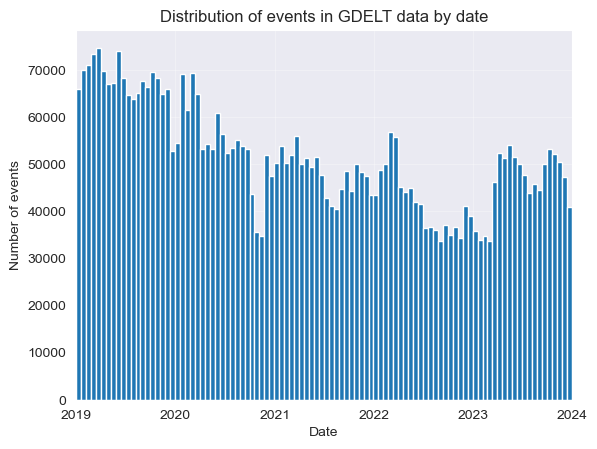

In [201]:
gdelt.date.hist(bins=100)
plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2024-01-01')])
plt.grid(True, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.title('Distribution of events in GDELT data by date')
plt.show()

We can see that the number of events tends to slowly decrease over time, but there are no significant gaps in the data.

In [202]:
description_df = gdelt.describe(include='all').T
description_df['present'] = description_df['count'] / gdelt.shape[0] * 100
description_df['present'] = description_df['present'].astype(int).astype(str) + '%'
description_df['share'] = description_df['freq'] / gdelt.shape[0]

In [203]:
description_df

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,present,share
date,5154269,NaN,NaN,NaN,2021-04-08 20:48:06.384392448,2019-01-01 00:00:00,2019-12-11 00:00:00,2021-02-21 00:00:00,2022-07-01 00:00:00,2023-12-31 00:00:00,NaN,100%,NaN
Actor1CountryCode,2312848,218,USA,495206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44%,0.096077
Actor1Type1Code,2694939,32,GOV,849116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52%,0.16474
Actor2CountryCode,1687063,218,USA,319636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32%,0.062014
Actor2Type1Code,1823482,32,GOV,523212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35%,0.10151
EventCode,5154269,252,010,394719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100%,0.076581
QuadClass,5154269,4,1,3113515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100%,0.604065
GoldsteinScale,5154246.0,NaN,NaN,NaN,0.503901,-10.0,-2.0,1.0,3.4,10.0,4.782016,99%,NaN
NumMentions,5154269.0,NaN,NaN,NaN,22.192037,11.0,16.0,20.0,20.0,2190.0,15.836417,100%,NaN
NumSources,5154269.0,NaN,NaN,NaN,2.295579,1.0,1.0,2.0,2.0,58.0,1.913006,100%,NaN


In [204]:
# There seem to be very few missing values in the GoldsteinScale column which is odd.
gdelt[gdelt['GoldsteinScale'].isna()].head(5)

,date,Actor1CountryCode,Actor1Type1Code,Actor2CountryCode,Actor2Type1Code,EventCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_CountryCode,Actor2Geo_CountryCode,ActionGeo_ADM1Code,DateAdded
232412,2021-12-10,NaN,JUD,USA,NaN,1213,3,NaN,20,1,20,-5.965227,US,US,US,20211210170000
297224,2021-01-06,NaN,JUD,USA,NaN,1213,3,NaN,16,2,16,-15.960979,US,US,US,20210106123000
397204,2019-01-30,NaN,OPP,USA,NaN,1213,3,NaN,20,1,20,-3.571429,MZ,US,US,20190130050000
437673,2019-06-12,NaN,OPP,CHN,NaN,1213,3,NaN,20,2,20,-7.342084,HK,CH,HK,20190612041500
590746,2021-03-30,NaN,NaN,GBR,NaN,1213,3,NaN,20,2,20,-5.220968,NaN,EZ,EZ,20210330064500


In [205]:
# the common factor seems to be their eventcode
gdelt[gdelt['GoldsteinScale'].isna()]['EventCode'].value_counts()

EventCode
1213    22
1214     1
Name: count, dtype: int64

In [206]:
# 1213 and 1214 correspond to rejection of judicial or intelligence cooperation. It is possible that these events are not rated on the Goldstein scale due to their nature but as we can't evaluate them either, we will drop them.
gdelt = gdelt[~gdelt['GoldsteinScale'].isna()]

### Bitcoin data preprocessing

In [207]:
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [208]:
# convert timestamp to datetime
bitcoin['date'] = pd.to_datetime(bitcoin['Timestamp'], unit='s')
bitcoin = bitcoin.drop(columns=['Timestamp'])

In [209]:
# we are interested only in 2019-2023
print(f"Before filtering:\t{bitcoin.shape[0]}")
bitcoin = bitcoin[(bitcoin['date'] >= '2019-01-01') & (bitcoin['date'] < '2024-01-02')]  # keeping the first day of 2024
print(f"After filtering:\t{bitcoin.shape[0]}")

Before filtering:	6709281
After filtering:	2630580


In [210]:
# we are interested in daily data
bitcoin = bitcoin.resample('D', on='date').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).reset_index()

In [211]:
bitcoin['Change'] = bitcoin['Close'] - bitcoin['Open']
bitcoin['Change%'] = bitcoin['Change'] / bitcoin['Open'] * 100
bitcoin['Change%'] = bitcoin['Change%'].round(2)
bitcoin['Fluctuation'] = bitcoin['High'] - bitcoin['Low']
bitcoin['Fluctuation%'] = bitcoin['Fluctuation'] / bitcoin['Open'] * 100
bitcoin['Fluctuation%'] = bitcoin['Fluctuation%'].round(2)

In [240]:
bitcoin.head()

,date,Open,High,Low,Close,Volume,Change,Change%,Fluctuation,Fluctuation%
0,2019-01-01,3750.62,3752.01,3629.66,3659.81,4860.346219,-90.81,-2.42,122.35,3.26
1,2019-01-02,3659.35,3890.00,3659.35,3850.00,5710.025088,190.65,5.21,230.65,6.30
2,2019-01-03,3850.00,3918.67,3760.00,3782.09,5678.792321,-67.91,-1.76,158.67,4.12
3,2019-01-04,3783.45,3850.33,3732.38,3757.66,6749.606969,-25.79,-0.68,117.95,3.12
4,2019-01-05,3757.66,3887.09,3753.04,3845.58,4141.245461,87.92,2.34,134.05,3.57


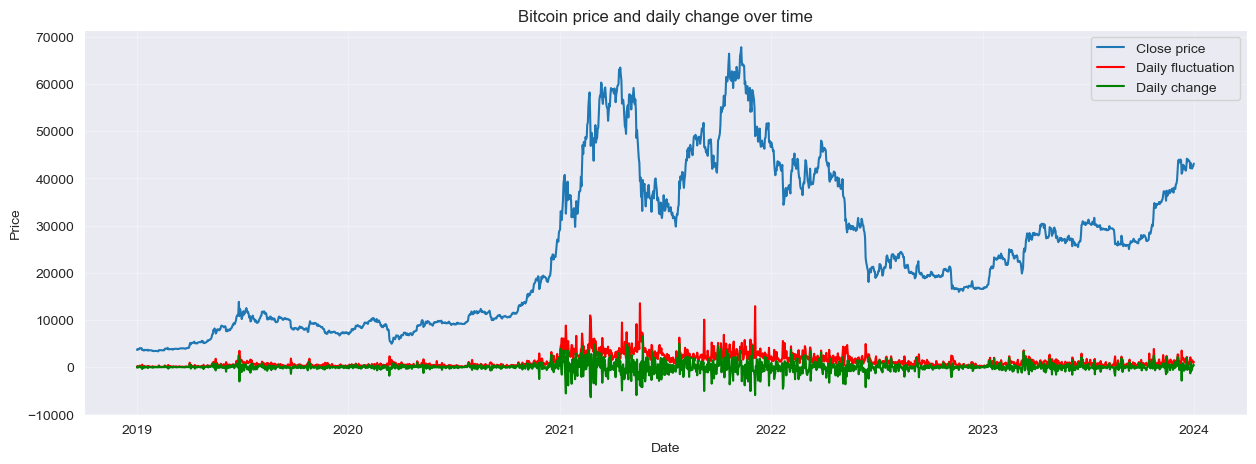

In [239]:
plt.figure(figsize=(15, 5))
plt.plot(bitcoin['date'], bitcoin['Close'])
plt.plot(bitcoin['date'], bitcoin['Fluctuation'], color='red')
plt.plot(bitcoin['date'], bitcoin['Change'], color='green')
plt.grid(True, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price and daily change over time')
plt.legend(['Close price', 'Daily fluctuation', 'Daily change'])
plt.show()